# iMet Collection 2019 - FGVC6
**Simple baseline for iMet Collection 2019 competition using fastai v1**

In [1]:
import torch
import dill as dill
import fastai
from fastai.vision import *
fastai.__version__

'1.0.51'

# Setup

In [2]:
BATCH  = 64
SIZE   = 256
path = Path('../input/imet-2019-fgvc6/') # iMet data path

# Data

In [3]:
# Load train dataframe
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


In [4]:
# Load labels dataframe
labels_df = pd.read_csv(path/'labels.csv')
labels_df.head()

,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [5]:
# Load sample submission
test_df = pd.read_csv(path/'sample_submission.csv')
test_df.head()

,id,attribute_ids
0,10023b2cc4ed5f68,0 1 2
1,100fbe75ed8fd887,0 1 2
2,101b627524a04f19,0 1 2
3,10234480c41284c6,0 1 2
4,1023b0e2636dcea8,0 1 2


# Create data object using datablock API

In [6]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=0.10, max_zoom=1.5, max_warp=0.2, max_lighting=0.2,
                      xtra_tfms=[(symmetric_warp(magnitude=(-0,0), p=0)),])

In [7]:
train, test = [ImageList.from_df(df, path=path, cols='id', folder=folder, suffix='.png') 
               for df, folder in zip([train_df, test_df], ['train', 'test'])]
data = (train.split_by_rand_pct(0.1, seed=42)
        .label_from_df(cols='attribute_ids', label_delim=' ')
        .add_test(test)
        .transform(tfms, size=SIZE, resize_method=ResizeMethod.PAD, padding_mode='border',)
        .databunch(path=Path('.'), bs=BATCH).normalize(imagenet_stats))

# Create learner with pretrenet model and FocalLoss
For problems with high class imbalance Focal Loss is usually a better choice than the usual Cross Entropy Loss.

In [8]:
# Source: https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/78109
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        return loss.mean()

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
    def forward(self, x):
        return x

In [10]:
# https://github.com/vivym/OctaveConv.pytorch/blob/master/models/octave_resnet.py

from functools import partial

import torch.nn as nn
import torch.nn.functional as F

class OctConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 alpha_in=0.25, alpha_out=0.25, type='normal'):
        super(OctConv, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.type = type
        hf_ch_in = int(in_channels * (1 - alpha_in))
        hf_ch_out = int(out_channels * (1 - alpha_out))
        lf_ch_in = in_channels - hf_ch_in
        lf_ch_out = out_channels - hf_ch_out

        if type == 'first':
            if stride == 2:
                self.downsample = nn.AvgPool2d(kernel_size=2, stride=stride)
            self.convh = nn.Conv2d(
                in_channels, hf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding,
            )
            self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
            self.convl = nn.Conv2d(
                in_channels, lf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding,
            )
        elif type == 'last':
            if stride == 2:
                self.downsample = nn.AvgPool2d(kernel_size=2, stride=stride)
            self.convh = nn.Conv2d(hf_ch_in, out_channels, kernel_size=kernel_size, padding=padding)
            self.convl = nn.Conv2d(lf_ch_in, out_channels, kernel_size=kernel_size, padding=padding)
            self.upsample = partial(F.interpolate, scale_factor=2, mode="nearest")
        else:
            if stride == 2:
                self.downsample = nn.AvgPool2d(kernel_size=2, stride=stride)

            self.L2L = nn.Conv2d(
                lf_ch_in, lf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding
            )
            self.L2H = nn.Conv2d(
                lf_ch_in, hf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding
            )
            self.H2L = nn.Conv2d(
                hf_ch_in, lf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding
            )
            self.H2H = nn.Conv2d(
                hf_ch_in, hf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding
            )
            self.upsample = partial(F.interpolate, scale_factor=2, mode="nearest")
            self.avg_pool = partial(F.avg_pool2d, kernel_size=2, stride=2)

    def forward(self, x):
        if self.type == 'first':
            if self.stride == 2:
                x = self.downsample(x)

            hf = self.convh(x)
            lf = self.avg_pool(x)
            lf = self.convl(lf)

            return hf, lf
        elif self.type == 'last':
            hf, lf = x
            if self.stride == 2:
                hf = self.downsample(hf)
                return self.convh(hf) + self.convl(lf)
            else:
                return self.convh(hf) + self.convl(self.upsample(lf))
        else:
            hf, lf = x
            if self.stride == 2:
                hf = self.downsample(hf)
                return self.H2H(hf) + self.L2H(lf), \
                       self.L2L(F.avg_pool2d(lf, kernel_size=2, stride=2)) + self.H2L(self.avg_pool(hf))
            else:
                return self.H2H(hf) + self.upsample(self.L2H(lf)), self.L2L(lf) + self.H2L(self.avg_pool(hf))


def norm_conv3x3(in_planes, out_planes, stride=1, type=None):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def norm_conv1x1(in_planes, out_planes, stride=1, type=None):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def oct_conv3x3(in_planes, out_planes, stride=1, type='normal'):
    """3x3 convolution with padding"""
    return OctConv(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, type=type)


def oct_conv1x1(in_planes, out_planes, stride=1, type='normal'):
    """1x1 convolution"""
    return OctConv(in_planes, out_planes, kernel_size=1, stride=stride, type=type)


class _BatchNorm2d(nn.Module):
    def __init__(self, num_features, alpha_in=0.25, alpha_out=0.25, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super(_BatchNorm2d, self).__init__()
        hf_ch = int(num_features * (1 - alpha_in))
        lf_ch = num_features - hf_ch
        self.bnh = nn.BatchNorm2d(hf_ch)
        self.bnl = nn.BatchNorm2d(lf_ch)

    def forward(self, x):
        hf, lf = x
        return self.bnh(hf), self.bnl(lf)


class _ReLU(nn.ReLU):
    def forward(self, x):
        hf, lf = x
        hf = super(_ReLU, self).forward(hf)
        lf = super(_ReLU, self).forward(lf)
        return hf, lf


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, type="normal", oct_conv_on=True):
        super(BasicBlock, self).__init__()
        conv3x3 = oct_conv3x3 if oct_conv_on else norm_conv3x3
        norm_func = _BatchNorm2d if oct_conv_on else nn.BatchNorm2d
        act_func = _ReLU if oct_conv_on else nn.ReLU
        

        self.conv1 = conv3x3(inplanes, planes, type="first" if type == "first" else "normal")
        self.bn1 = norm_func(planes)
        self.relu1 = act_func(inplace=True)
        self.conv2 = conv3x3(planes, planes, stride, type="last" if type == "last" else "normal")
        if type == "last":
            norm_func = nn.BatchNorm2d
            act_func = nn.ReLU
        self.bn2 = norm_func(planes)
        self.relu2 = act_func(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        if isinstance(out, (tuple, list)):
            assert len(out) == len(identity) and len(out) == 2
            out = (out[0] + identity[0], out[1] + identity[1])
        else:
            out += identity

        out = self.relu2(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, type="normal", oct_conv_on=True):
        super(Bottleneck, self).__init__()
        conv1x1 = oct_conv1x1 if oct_conv_on else norm_conv1x1
        conv3x3 = oct_conv3x3 if oct_conv_on else norm_conv3x3
        norm_func = _BatchNorm2d if oct_conv_on else nn.BatchNorm2d
        act_func = _ReLU if oct_conv_on else nn.ReLU

        self.conv1 = conv1x1(inplanes, planes, type="first" if type == "first" else "normal")
        self.bn1 = norm_func(planes)
        self.relu1 = act_func(inplace=True)
        self.conv2 = conv3x3(planes, planes, stride, type="last" if type == "last" else "normal")
        if type == "last":
            conv1x1 = norm_conv1x1
            norm_func = nn.BatchNorm2d
            act_func = nn.ReLU
        self.bn2 = norm_func(planes)
        self.relu2 = act_func(inplace=True)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm_func(planes * self.expansion)
        self.relu3 = act_func(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        if isinstance(out, (tuple, list)):
            assert len(out) == len(identity) and len(out) == 2
            out = (out[0] + identity[0], out[1] + identity[1])
        else:
            out += identity
        out = self.relu3(out)

        return out


class OctResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1103, zero_init_residual=False):
        super(OctResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], type="first")
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, type="last")
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, type="normal"):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion or type=='first':
            norm_func = nn.BatchNorm2d if type == "last" else _BatchNorm2d
            downsample = nn.Sequential(
                oct_conv1x1(self.inplanes, planes * block.expansion, stride, type=type),
                norm_func(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, type=type))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, oct_conv_on=type != "last"))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def octave_resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = OctResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    num_ftrs = model.fc.in_features
    model.fc = Classifier()
    mlp = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs),
            nn.ReLU(),
            nn.BatchNorm1d(num_ftrs),
            nn.Dropout(0.25),
            nn.Linear(num_ftrs, 1103)
    )
    net = nn.Sequential(
            model,
            mlp
            #nn.Sigmoid()
    )
    return net


def octave_resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = OctResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    num_ftrs = model.fc.in_features
    model.fc = Classifier()
    mlp = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs),
            nn.ReLU(),
            nn.BatchNorm1d(num_ftrs),
            nn.Dropout(0.25),
            nn.Linear(num_ftrs, 1103)
    )
    net = nn.Sequential(
            model,
            mlp
            #nn.Sigmoid()
    )
    return net


def octave_resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = OctResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    num_ftrs = model.fc.in_features
    model.fc = Classifier()
    mlp = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs),
            nn.ReLU(),
            nn.BatchNorm1d(num_ftrs),
            nn.Dropout(0.25),
            nn.Linear(num_ftrs, 1103)
    )
    net = nn.Sequential(
            model,
            mlp
            #nn.Sigmoid()
    )
    return net


def octave_resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = OctResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    num_ftrs = model.fc.in_features
    model.fc = Classifier()
    mlp = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs),
            nn.ReLU(),
            nn.BatchNorm1d(num_ftrs),
            nn.Dropout(0.25),
            nn.Linear(num_ftrs, 1103)
    )
    net = nn.Sequential(
            model,
            mlp
            #nn.Sigmoid()
    )
    return net


def octave_resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = OctResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

In [11]:
#learn = Learner(data, simple_cnn((3,16,16,2)), loss_func=FocalLoss(), metrics=fbeta)
learn = Learner(data, octave_resnet50(), loss_func=FocalLoss(), metrics=fbeta)

In [12]:
#learn

# Train the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


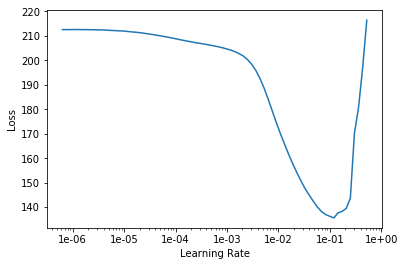

In [13]:
# Find a good learning rate
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.unfreeze()
learn.fit_one_cycle(14)
#learn.fit(10)
#learn.freeze()
#learn.save('Oct-ResNet18', return_path=True)
torch.save(learn.model.state_dict(), 'Oct-ResNet50.pth', pickle_module=dill)

epoch,train_loss,valid_loss,fbeta,time
0,4.909148,6.308769,0.190422,35:56


In [15]:
os.listdir('./')

['__notebook__.ipynb', '__output__.json', 'Oct-ResNet50.pth', 'models']

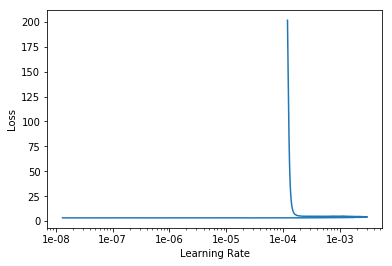

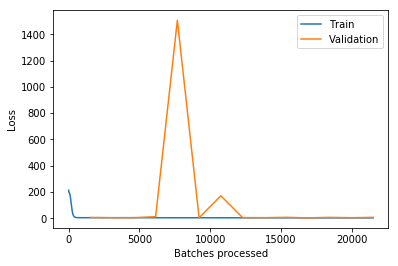

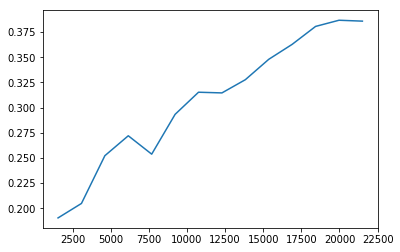

In [16]:
learn.recorder.plot()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [17]:
#learn.export()

# Get predictions

In [18]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in progress_bar(thrs):
        score.append(fbeta(valid_preds[0],valid_preds[1], thresh=thr))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr

i2c = np.array([[i, c] for c, i in learn.data.train_ds.y.c2i.items()]).astype(int) # indices to class number correspondence

def join_preds(preds, thr):
    return [' '.join(i2c[np.where(t==1)[0],1].astype(str)) for t in (preds[0].sigmoid()>thr).long()]

thr=0.290 F2=0.456


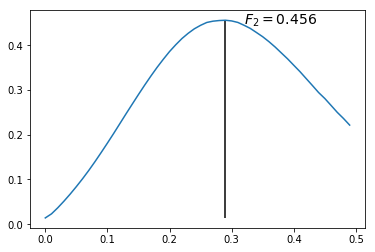

In [19]:
# Validation predictions
valid_preds = learn.get_preds(DatasetType.Valid)
best_thr = find_best_fixed_threshold(*valid_preds)

In [20]:
# Test predictions
#test_preds = learn.get_preds(DatasetType.Test)
#test_df.attribute_ids = join_preds(test_preds, best_thr)
#test_df.head()

In [21]:
#test_df.to_csv('submission.csv', index=False)

## TTA

In [22]:
# Validation predictions with TTA
#valid_preds = learn.TTA(ds_type=DatasetType.Valid)
#best_thr = find_best_fixed_threshold(*valid_preds)

In [23]:
# Test predictions with TTA
#test_preds = learn.TTA(ds_type=DatasetType.Test)
#test_df.attribute_ids = join_preds(test_preds, best_thr)
#test_df.head()

In [24]:
#test_df.to_csv('submission.csv', index=False) 